In [ ]:
from IPython.display import HTML, Javascript

HTML("""
<style>
/* Initialize counters once for the whole document */
body { counter-reset: h1 h2 h3 h4; }

/* Number headings inside rendered markdown blocks */
.jp-Notebook .jp-RenderedHTMLCommon h1::before {
  counter-increment: h1;
  counter-reset: h2;
  content: counter(h1) ". ";
}

.jp-Notebook .jp-RenderedHTMLCommon h2::before {
  counter-increment: h2;
  counter-reset: h3;
  content: counter(h1) "." counter(h2) " ";
}

.jp-Notebook .jp-RenderedHTMLCommon h3::before {
  counter-increment: h3;
  counter-reset: h4;
  content: counter(h1) "." counter(h2) "." counter(h3) " ";
}

.jp-Notebook .jp-RenderedHTMLCommon h4::before {
  counter-increment: h4;
  content: counter(h1) "." counter(h2) "." counter(h3) "." counter(h4) " ";
}

/* Hide the number for the single, global title H1 (but keep the increment) */
.jp-Notebook .jp-RenderedHTMLCommon h1.jp-title-skip::before {
  content: "";
  display: none;
}
</style>
""")
# ... existing code ...

# Tag the first H1 in the entire notebook so we can hide its number without breaking counters
Javascript("""
(() => {
  const nb = document.querySelector('.jp-Notebook');
  if (!nb) return;
  const h1s = nb.querySelectorAll('.jp-RenderedHTMLCommon h1');
  if (h1s.length) {
    h1s[0].classList.add('jp-title-skip');
  }
})();
""")


# Heart Disease Prediction
Author: Seán Coffey
Date: September 2025


## Objectives
Purpose: Build and evaluate models to predict heart disease from clinical features.
Key outcomes: a) clean dataset, b) strong baseline, c) validated model, d) interpretable insights.

## Project Setup


### Reproducibility


In [81]:
import os
import sys
import random
import numpy as np
import pandas as pd
import kagglehub   # need this to download dataset
import math

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    RocCurveDisplay, PrecisionRecallDisplay
)

from pathlib import Path
from tqdm.autonotebook import tqdm as notebook_tqdm

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# Plotting defaults
sns.set_theme(context="notebook", style="darkgrid", palette="deep")
plt.rcParams.update({
    "figure.figsize": (8, 5),
    "figure.dpi": 120,
    "axes.titlesize": 14,
    "axes.labelsize": 12
})

print("Python:", sys.version.split()[0])
print("Pandas:", pd.__version__)

Python: 3.11.13
Pandas: 2.3.2


### Data Access

In [37]:
# Download latest version of dataset
path = kagglehub.dataset_download("redwankarimsony/heart-disease-data")
print("Path to dataset files:", path)
p = Path(path)

files = [f.name for f in p.iterdir() if f.is_file()]
print("Files in folder:")
for name in files:
    print("-", name)

csv_files = sorted(p.rglob("*.csv"))  # search recursively
if not csv_files:
    raise FileNotFoundError(f"No CSV files found under {p}")
heart_data = pd.read_csv(csv_files[0])
print("Loaded:", csv_files[0].name, heart_data.shape)
heart_data.head()

Path to dataset files: /Users/seancoffey/.cache/kagglehub/datasets/redwankarimsony/heart-disease-data/versions/6
Files in folder:
- heart_disease_uci.csv
Loaded: heart_disease_uci.csv (920, 16)


,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


### About the Dataset

**Kaggle web-page:** https://www.kaggle.com/datasets/redwankarimsony/heart-disease-data/data

#### Summary

This is a multivariate type of dataset which means providing or involving a variety of separate mathematical or statistical variables, multivariate numerical data analysis. It is composed of 14 attributes which are age, sex, chest pain type, resting blood pressure, serum cholesterol, fasting blood sugar, resting electrocardiographic results, maximum heart rate achieved, exercise-induced angina, oldpeak — ST depression induced by exercise relative to rest, the slope of the peak exercise ST segment, number of major vessels and Thalassemia. This database includes 76 attributes, but all published studies relate to the use of a subset of 14 of them. The Cleveland database is the only one used by ML researchers to date. One of the major tasks on this dataset is to predict based on the given attributes of a patient that whether that particular person has heart disease or not and other is the experimental task to diagnose and find out various insights from this dataset which could help in understanding the problem more.

#### Features

- id (Unique id for each patient)
- age (Age of the patient in years) - range: 28 to 77
- sex (Male/Female)
- dataset (place of study) ['Cleveland' 'Hungary' 'Switzerland' 'VA Long Beach']
- cp chest pain type ([typical angina, atypical angina, non-anginal, asymptomatic])
- trestbps resting blood pressure (resting blood pressure (in mm Hg on admission to the hospital))
- chol (serum cholesterol in mg/dl) - range: 0(missing value?) to 603
- fbs (if fasting blood sugar > 120 mg/dl) - Boolean (1 = true; 0 = false)
- restecg (resting electrocardiographic results), Values: [normal, stt abnormality, lv hypertrophy]
- thalach: maximum heart rate achieved - range: 60 to 202
- exang: exercise-induced angina (True/ False)
- oldpeak: ST depression induced by exercise relative to rest, it indicates an abnormality in heart's electrical activity and is characterized by a downward deflection of ST segment (in ECG results). Range: -2.6 to 6.2
- slope: the slope of the peak exercise ST segment, Values: [upsloping, flat, downsloping]
- ca: number of major vessels (0-3) colored by fluoroscopy
- thal: [normal; fixed defect; reversible defect]
- num: the predicted attribute, Values: [0,1,2,3,4] - meaning the extent of heart disease [none, mild, moderate, severe, critical]

In [38]:
display(heart_data.info())
display(heart_data.describe(include="all"))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        920 non-null    int64  
 1   age       920 non-null    int64  
 2   sex       920 non-null    object 
 3   dataset   920 non-null    object 
 4   cp        920 non-null    object 
 5   trestbps  861 non-null    float64
 6   chol      890 non-null    float64
 7   fbs       830 non-null    object 
 8   restecg   918 non-null    object 
 9   thalch    865 non-null    float64
 10  exang     865 non-null    object 
 11  oldpeak   858 non-null    float64
 12  slope     611 non-null    object 
 13  ca        309 non-null    float64
 14  thal      434 non-null    object 
 15  num       920 non-null    int64  
dtypes: float64(5), int64(3), object(8)
memory usage: 115.1+ KB


None

,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
count,920.000000,920.000000,920,920,920,861.000000,890.000000,830,918,865.000000,865,858.000000,611,309.000000,434,920.000000
unique,NaN,NaN,2,4,4,NaN,NaN,2,3,NaN,2,NaN,3,NaN,3,NaN
top,NaN,NaN,Male,Cleveland,asymptomatic,NaN,NaN,False,normal,NaN,False,NaN,flat,NaN,normal,NaN
freq,NaN,NaN,726,304,496,NaN,NaN,692,551,NaN,528,NaN,345,NaN,196,NaN
mean,460.500000,53.510870,NaN,NaN,NaN,132.132404,199.130337,NaN,NaN,137.545665,NaN,0.878788,NaN,0.676375,NaN,0.995652
std,265.725422,9.424685,NaN,NaN,NaN,19.066070,110.780810,NaN,NaN,25.926276,NaN,1.091226,NaN,0.935653,NaN,1.142693
min,1.000000,28.000000,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,60.000000,NaN,-2.600000,NaN,0.000000,NaN,0.000000
25%,230.750000,47.000000,NaN,NaN,NaN,120.000000,175.000000,NaN,NaN,120.000000,NaN,0.000000,NaN,0.000000,NaN,0.000000
50%,460.500000,54.000000,NaN,NaN,NaN,130.000000,223.000000,NaN,NaN,140.000000,NaN,0.500000,NaN,0.000000,NaN,1.000000
75%,690.250000,60.000000,NaN,NaN,NaN,140.000000,268.000000,NaN,NaN,157.000000,NaN,1.500000,NaN,1.000000,NaN,2.000000


##  Exploratory Data Analysis (EDA)

In [39]:
# Check data for categorical columns
catgoricals = ['sex','dataset','cp','fbs','restecg','exang','slope','thal','num']
for col in catgoricals:
    print(f'{col}: {heart_data[col].unique()}')
#heart_data[catgoricals] = heart_data[catgoricals].astype('category')
print(f"\nFor {heart_data.shape[0]} rows we have [heart_data['id'].nunique()] patient IDs.\n") # check num rows = num patients

target_col = "num"  # adjust to your dataset
ratios_pct_str = (heart_data[target_col].value_counts(normalize=True).mul(100).round(1).astype(str) + "%")
print(f'The class ratios given target variable {ratios_pct_str}')

sex: ['Male' 'Female']
dataset: ['Cleveland' 'Hungary' 'Switzerland' 'VA Long Beach']
cp: ['typical angina' 'asymptomatic' 'non-anginal' 'atypical angina']
fbs: [True False nan]
restecg: ['lv hypertrophy' 'normal' 'st-t abnormality' nan]
exang: [False True nan]
slope: ['downsloping' 'flat' 'upsloping' nan]
thal: ['fixed defect' 'normal' 'reversable defect' nan]
num: [0 2 1 3 4]

For 920 rows we have [heart_data['id'].nunique()] patient IDs.

The class ratios given target variable num
0    44.7%
1    28.8%
2    11.8%
3    11.6%
4     3.0%
Name: proportion, dtype: object


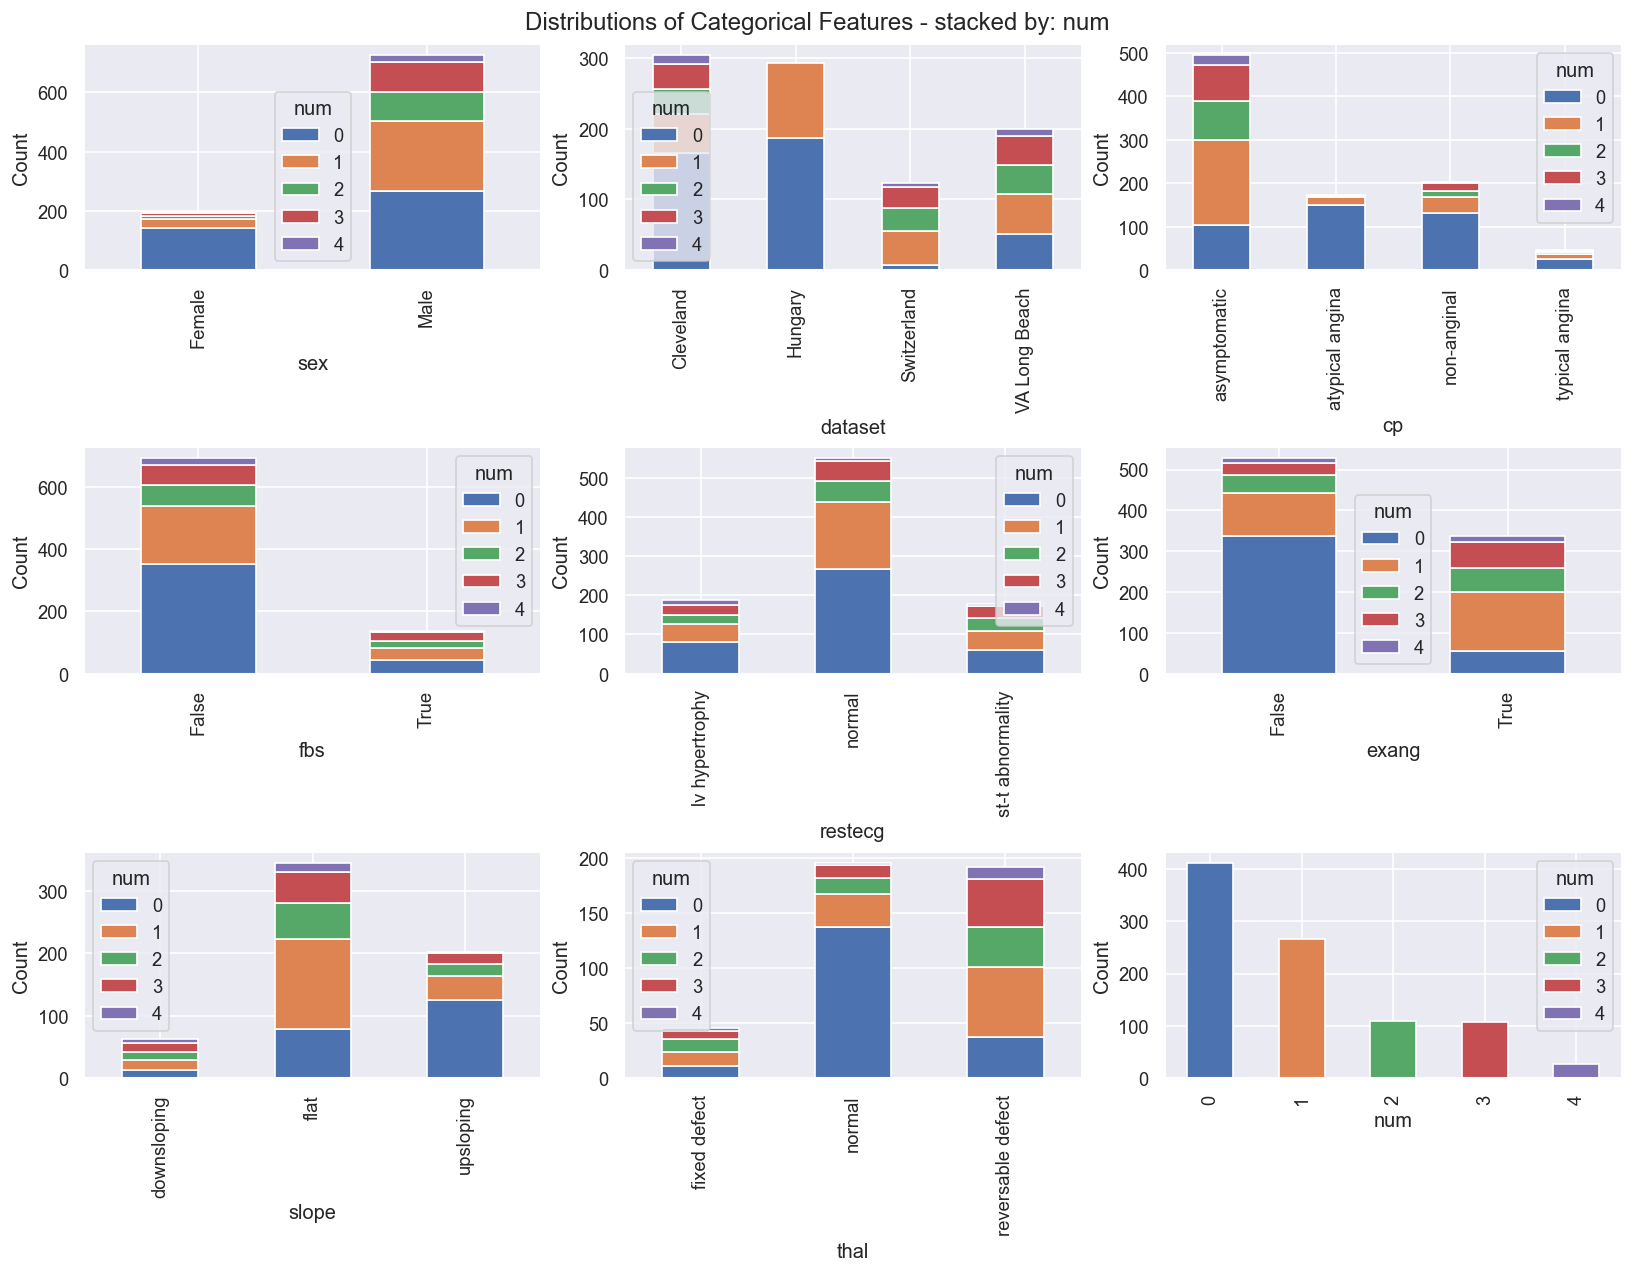


 -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- 



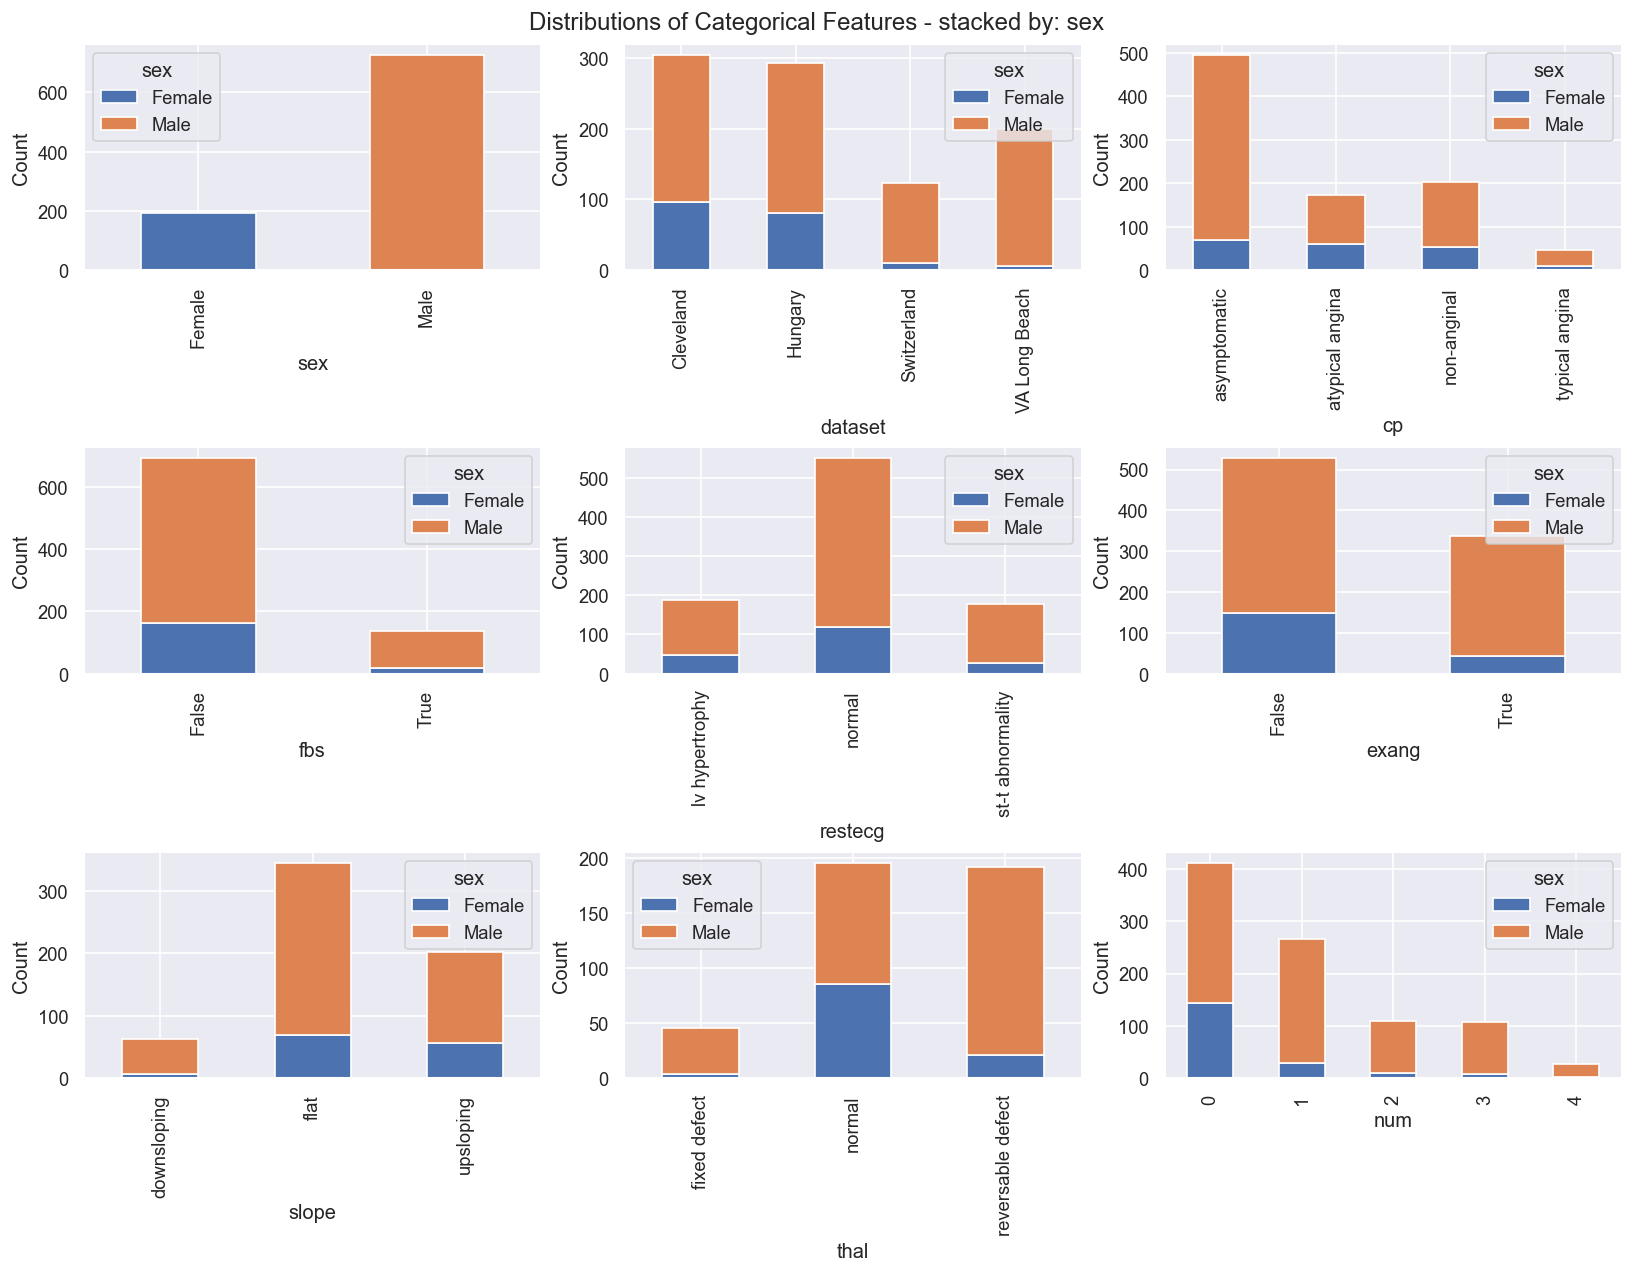


 -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- 



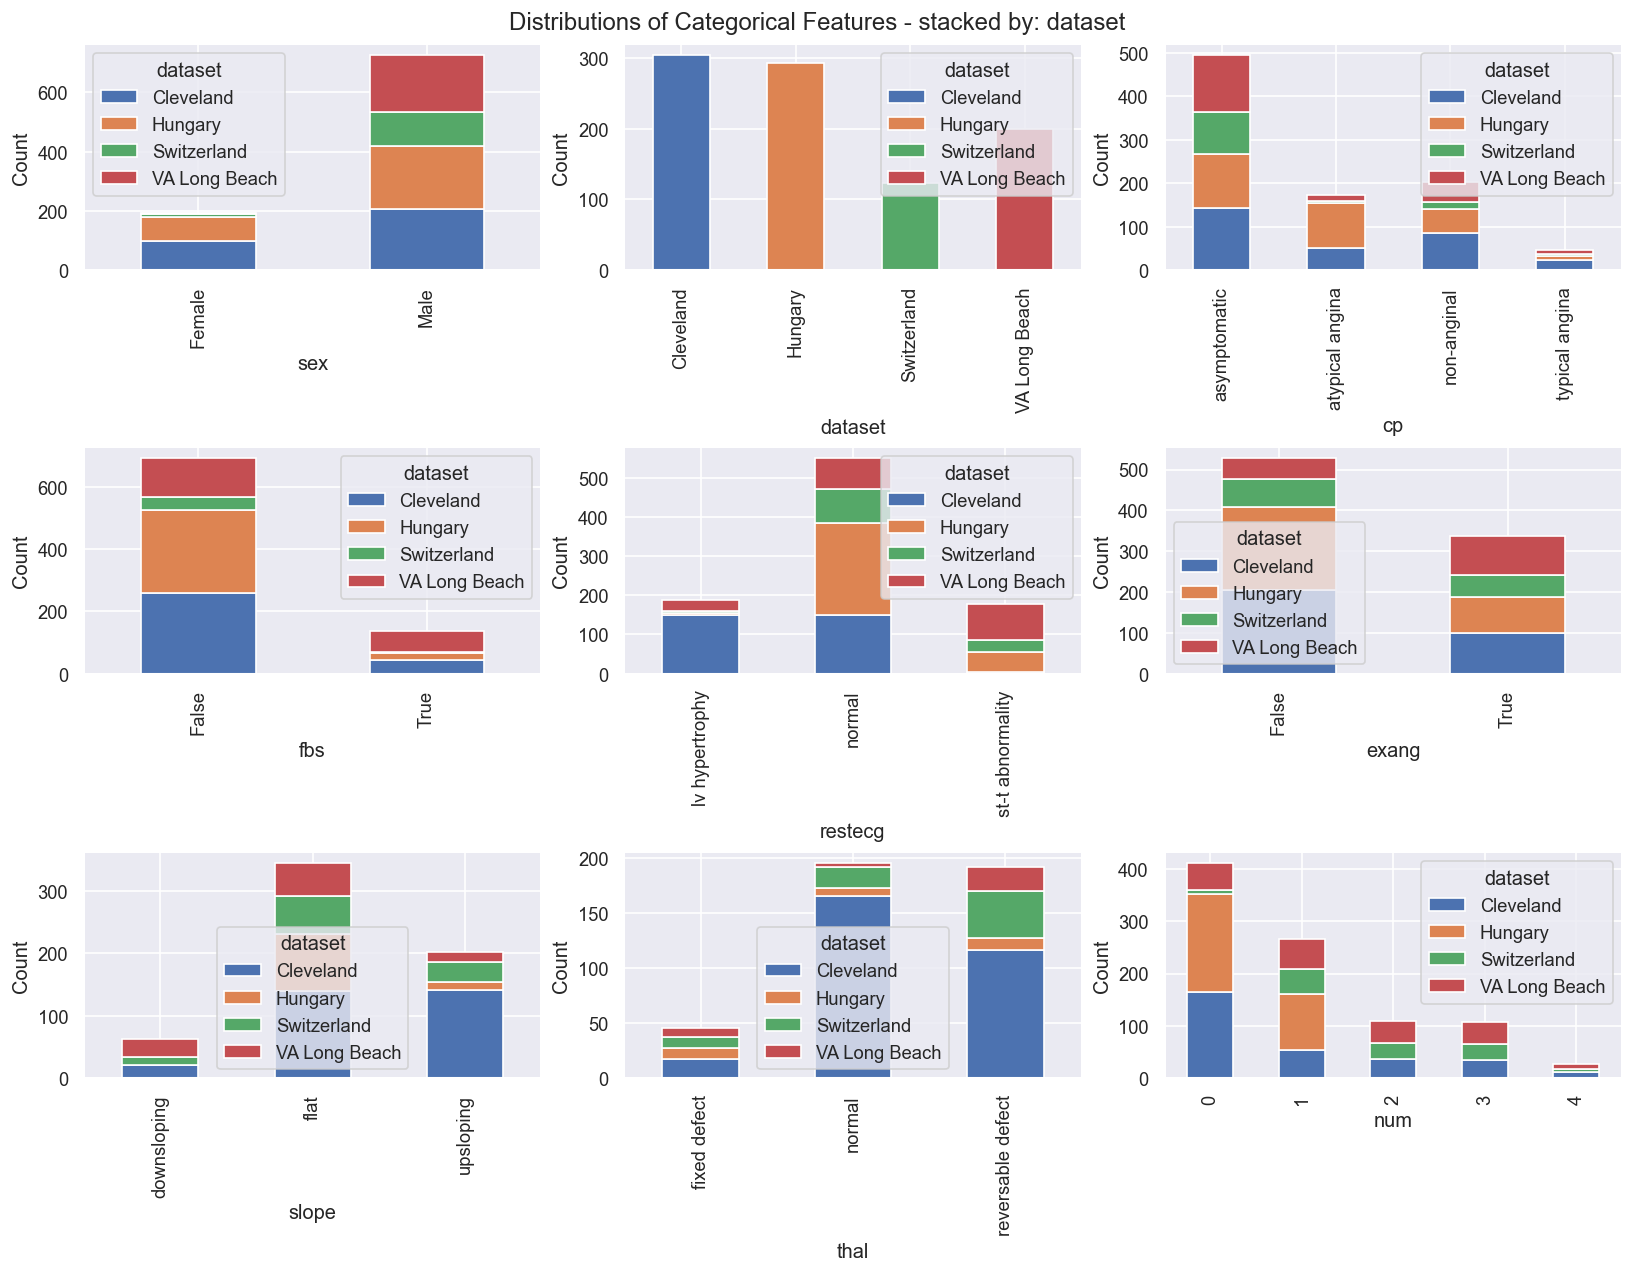


 -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- 



In [74]:
# Explore categoricals
n = len(catgoricals)
n_cols = 3
n_rows = math.ceil(n / n_cols)

def section_split(width=200, char="-"):
    print("\n", char * width, "\n")

def stacked_count_plot(stack):
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4.5, n_rows * 3.5), constrained_layout=True)
    axes = np.array(axes).reshape(-1)  # flatten in case of single row/col

    for i, col in enumerate(catgoricals):
        ax = axes[i]
        pd.crosstab(heart_data[col], heart_data[stack]).plot(kind="bar", stacked=True, ax=ax)
        ax.set_xlabel(col)
        ax.set_ylabel("Count")

    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)

    fig.suptitle("Distributions of Categorical Features - stacked by: " + stack)
    plt.show()

# Stacking by target variable - a visual indication of which categorical features are most important
stacked_count_plot("num")
section_split()

# Stacking by sex - is the data very different for male/female?
stacked_count_plot('sex')
section_split()

# Stacking by dataset - is the data different for different locations?
stacked_count_plot('dataset')
section_split()


### Categorical Data Observations
1. The ratio of male to female in the data is approx 3:1 overall and there is almost no female data in the Switzerland or VA Long Beach datasets
2. The data by location(dataset) is very differently distributed. Hungary has no serious cases of serious heart disease (or were they using a more limited binary classification?)
3. Resting ECG (restecg) seems to be (based on visual inspection) a strong indicator of likelihood of heart disease.
4. As does exercised induced angina (exang).
5. The target ('num') has five levels, it may be useful to replace with a binary column (e.g. 0=no, 1=yes) to facilitate modelling.


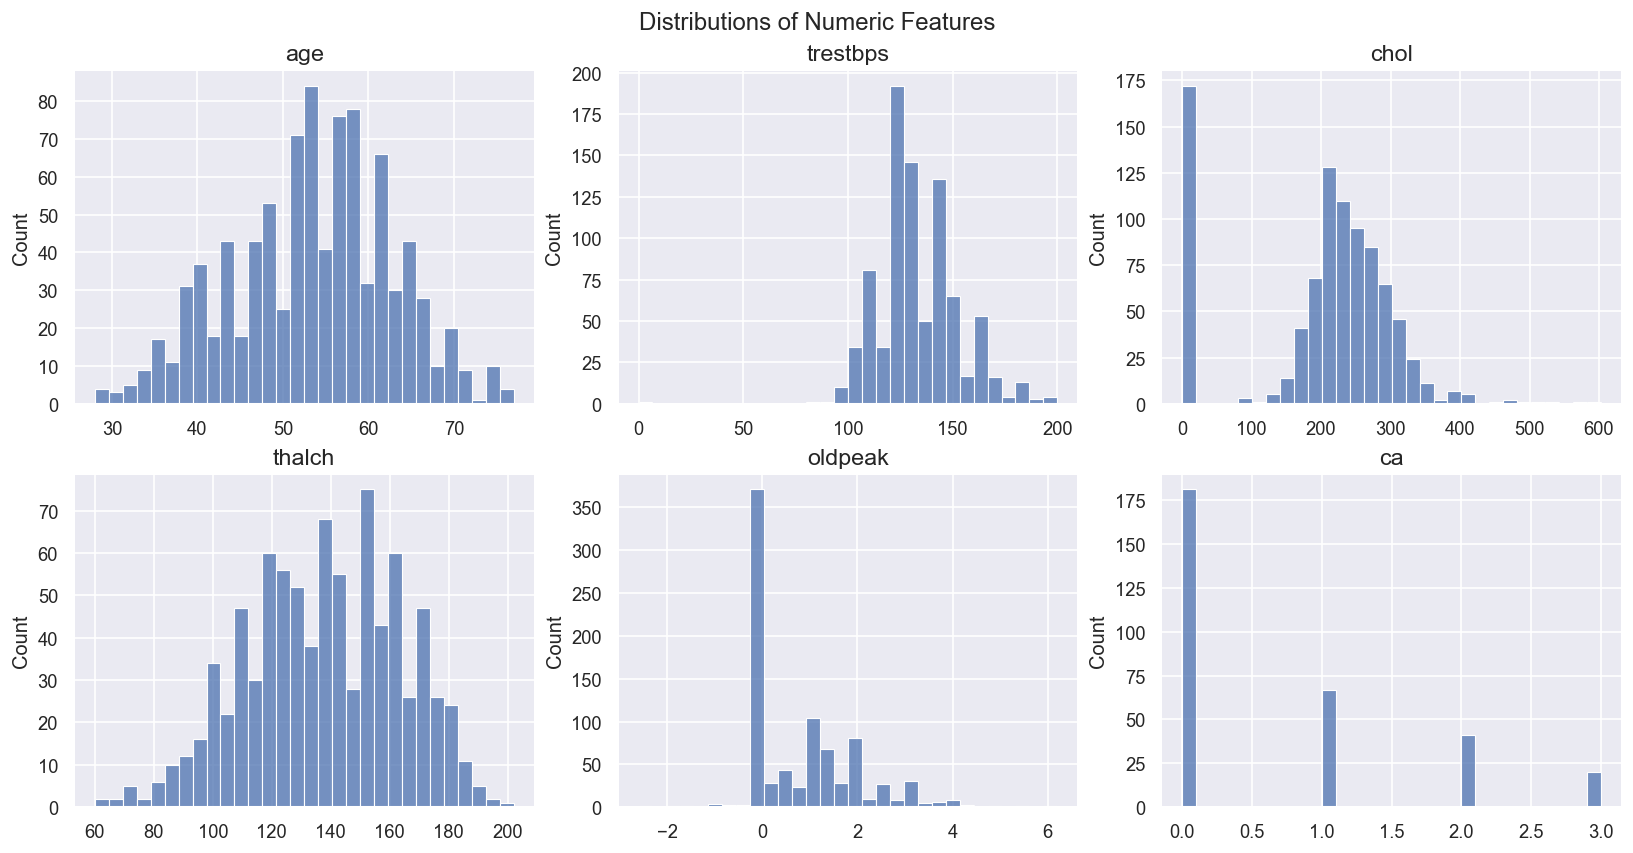

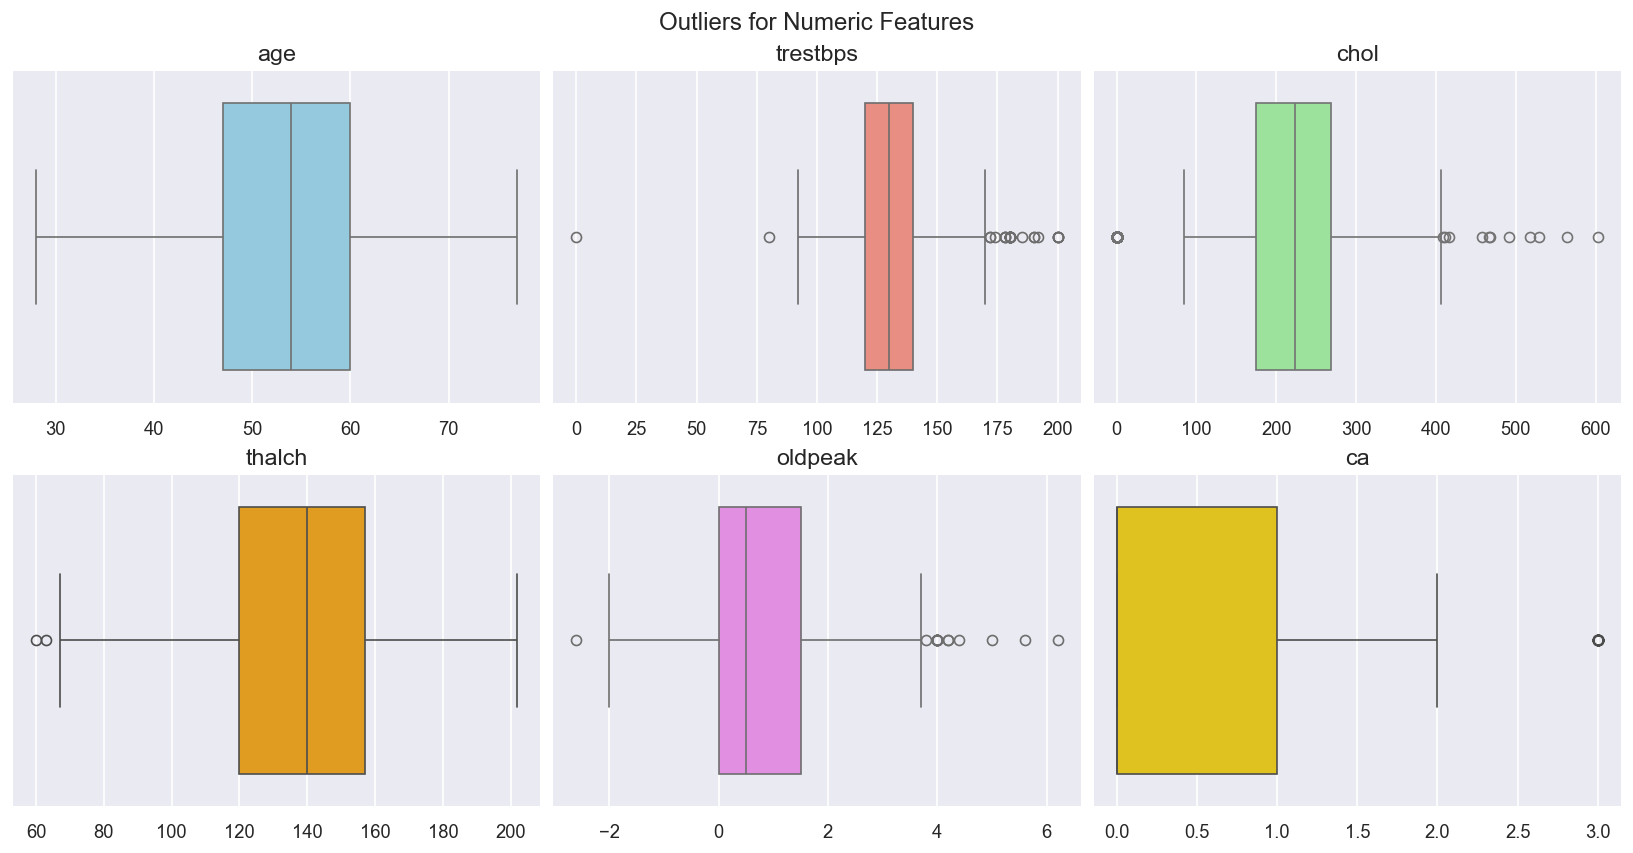

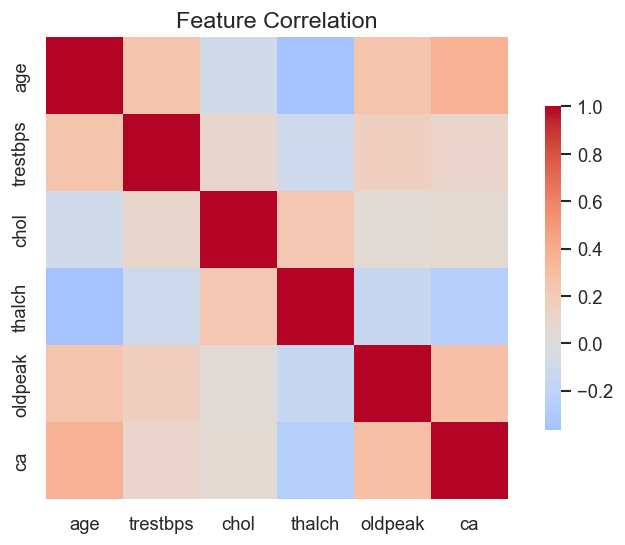

In [51]:
# Explore numeric columns
numeric_cols = ['age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'ca']
n = len(numeric_cols)
n_cols = 3
n_rows = math.ceil(n / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4.5, n_rows * 3.5), constrained_layout=True)
axes = np.array(axes).reshape(-1)  # flatten in case of single row/col

# Plot distributions for numeric columns
for i, col in enumerate(numeric_cols):
    ax = axes[i]
    sns.histplot(heart_data[col].dropna(), bins=30, kde=False, ax=ax)
    ax.set_title(col)
    ax.set_xlabel("")
    ax.set_ylabel("Count")

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

fig.suptitle("Distributions of Numeric Features")
plt.show()

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4.5, n_rows * 3.5), constrained_layout=True)
axes = np.array(axes).reshape(-1)  # flatten in case of single row/col

# Show outliers for numeric columns
colors = ["skyblue", "salmon", "lightgreen", "orange", "violet", "gold"]
for i, col in enumerate(numeric_cols):
    ax = axes[i]
    sns.boxplot(x = heart_data[col], ax=ax, color=colors[i])
    ax.set_title(col)
    ax.set_xlabel("")

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

fig.suptitle("Outliers for Numeric Features")
plt.show()

# Correlation heatmap
corr = heart_data[numeric_cols].corr(numeric_only=True)
sns.heatmap(corr, cmap="coolwarm", center=0, square=True, cbar_kws={"shrink": 0.7})
plt.title("Feature Correlation")
plt.show()


### Numerical Feature Observations
1. There are no strong correlations between numerical features to concern us.
2. The age distribution is a little skewed to the right (older patients).
3. Distributions look ok, but we should worry about the meaning of zero values for cholesterol and oldpeak
4. We may need to remove outliers for trestbps, chol, thalch, oldpeak and ca. (need to check further first)

id            0.0%
age           0.0%
sex           0.0%
dataset       0.0%
cp            0.0%
trestbps     6.41%
chol         3.26%
fbs          9.78%
restecg      0.22%
thalch       5.98%
exang        5.98%
oldpeak      6.74%
slope       33.59%
ca          66.41%
thal        52.83%
num           0.0%
dtype: object


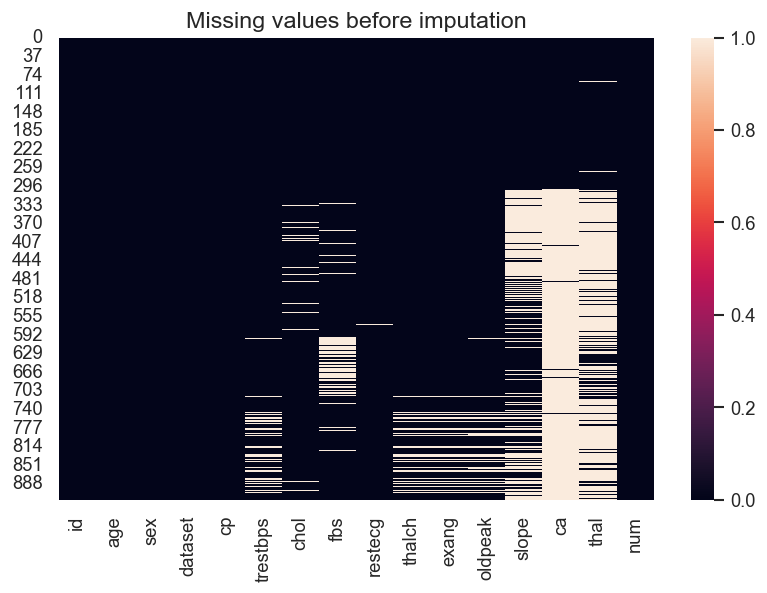

Rows per dataset:
 dataset
Cleveland        304
Hungary          293
VA Long Beach    200
Switzerland      123
Name: count, dtype: int64 

                id  age  sex   cp  trestbps  chol    fbs  restecg  thalch  \
dataset                                                                     
Cleveland      0.0  0.0  0.0  0.0      0.00  0.00   0.00     0.00    0.00   
Hungary        0.0  0.0  0.0  0.0      0.34  7.85   2.73     0.34    0.34   
Switzerland    0.0  0.0  0.0  0.0      1.63  0.00  60.98     0.81    0.81   
VA Long Beach  0.0  0.0  0.0  0.0     28.00  3.50   3.50     0.00   26.50   

               exang  oldpeak  slope     ca   thal  num  
dataset                                                  
Cleveland       0.00     0.00   0.33   1.64   0.99  0.0  
Hungary         0.34     0.00  64.51  98.98  90.44  0.0  
Switzerland     0.81     4.88  13.82  95.93  42.28  0.0  
VA Long Beach  26.50    28.00  51.00  99.00  83.00  0.0  


In [65]:
# Explore Missing Values
print(round(heart_data.isnull().sum() * 100 / len(heart_data), 2).astype(str) + '%')
sns.heatmap(heart_data.isnull())
plt.title('Missing values before imputation')
plt.show()

# do missing values vary by location (dataset)?
group_col = "dataset"
value_cols = heart_data.columns.drop(group_col)

row_counts = heart_data[group_col].value_counts(dropna=False)
print("Rows per dataset:\n", row_counts, "\n")

null_pct_by_dataset = (
    heart_data
    .groupby(group_col, dropna=False)[value_cols]
    .apply(lambda g: g.isna().mean().mul(100))
    .round(2)
)

print(null_pct_by_dataset)


### Missing Value Observations
1. ca, slope and thal are to a large extent missing from all locations except Cleveland.
2. In fact the only location that doesn't have some form of missing data is Cleveland.
3. VA Long Beach has significant missing data in all features that are likely to have predictive value.

The extent of the missing data suggests that blanket use of imputation may not be a good idea:
1. Deep domain knowledge is needed to know whether imputing a mean, a mode or using KNN is really the right thing to do.
2. Any predictive model (the objective of this project) would have limited credibility with this number of manufactured features.

There are two possible ways forward
1. Produce a model limited to the Cleveland dataset, which still has n = 304
2. Remove the features with missing data (slope, ca and thal) and train a model on the remaining features. For this option, we would still need to remove VA Long Beach if we want any features beyond chol and ecg to play with.

At this stage, I am uncertain which option I prefer, so I will work with Cleveland first and try to judge how it may or may not be extendable to include the other locations. This may mean revisiting the pre-processing steps for the broader dataset.

It is already becoming clear how important domain knowledge is to effective modelling. If the objective was to produce a model usable in the field, I would first find a way to get some domain help with these data issues. However, for this project I am going to focus on the modelling aspect.

## Preprocessing
- Add a binary target column (1 = heart disease, 0 = no heart disease)
- Basic imputation/cleanup
- Train/test split
- Scaling if needed - not sure yet
- one-hot encoding - not sure yet

In [75]:
# Start by creating the two base datasets
# cleveland_heart with only one location but maintaining all the features
cleveland_heart = heart_data[heart_data['dataset'] == 'Cleveland'].copy()
# in case we need it later the simple_heart extended datasets with removed features
simple_heart = heart_data[heart_data['dataset'] != 'VA Long Beach'].copy()
simple_heart.drop(['slope','ca','thal'], axis=1, inplace=True)

In [80]:
# Look at the missing values again
print("For Cleveland:\n", round(cleveland_heart.isnull().sum() * 100 / len(cleveland_heart), 2).astype(str) + '%')
print("\nFor Simple:\n", round(simple_heart.isnull().sum() * 100 / len(simple_heart), 2).astype(str) + '%')
# Checking Cleveland data more carefully
rows_with_counts = (
    cleveland_heart.assign(n_missing=cleveland_heart.isna().sum(axis=1))
      .query("n_missing > 0")
      .sort_values("n_missing", ascending=False)
)
print(rows_with_counts)


For Cleveland:
 id           0.0%
age          0.0%
sex          0.0%
dataset      0.0%
cp           0.0%
trestbps     0.0%
chol         0.0%
fbs          0.0%
restecg      0.0%
thalch       0.0%
exang        0.0%
oldpeak      0.0%
slope       0.33%
ca          1.64%
thal        0.99%
num          0.0%
dtype: object

For Simple:
 id            0.0%
age           0.0%
sex           0.0%
dataset       0.0%
cp            0.0%
trestbps     0.42%
chol         3.19%
fbs         11.53%
restecg      0.28%
thalch       0.28%
exang        0.28%
oldpeak      0.83%
num           0.0%
dtype: object
      id  age     sex    dataset               cp  trestbps   chol    fbs  \
303  304   28    Male  Cleveland  atypical angina     130.0  132.0  False   
87    88   53  Female  Cleveland      non-anginal     128.0  216.0  False   
166  167   52    Male  Cleveland      non-anginal     138.0  223.0  False   
192  193   43    Male  Cleveland     asymptomatic     132.0  247.0   True   
266  267   52    Male 

### Missing Values and Outliers
For the Cleveland dataset:
- Remove row 303 which has 3 missing values
- The other 6 rows with missing values have one missing value, all of them are categorical (ca is ordinal), so using a simple imputer is a reasonable choice.
- Without domain knowledge, it is probably best to keep the outliers, I have no idea if they are plausible or not. None of them seem to have a data-quality based explanation (e.g. 0 or infinity as entries)

In [97]:
# Cleveland Cleaning
# Drop row 303 which has 3 missing values
if 303 in cleveland_heart.index:
    cleveland_heart = cleveland_heart.drop(index=303)
# impute missing values for slope, ca and thal using most frequent value
cat_imp = SimpleImputer(strategy="most_frequent")
imputed_cols = pd.DataFrame(
    cat_imp.fit_transform(cleveland_heart[['thal', 'ca']]),
    columns=['thal', 'ca'],
    index=cleveland_heart.index
)
cleveland_clean = cleveland_heart.copy()
cleveland_clean[['thal', 'ca']] = imputed_cols

assert cleveland_clean.isnull().sum().sum() == 0, "Missing values remain after imputation"


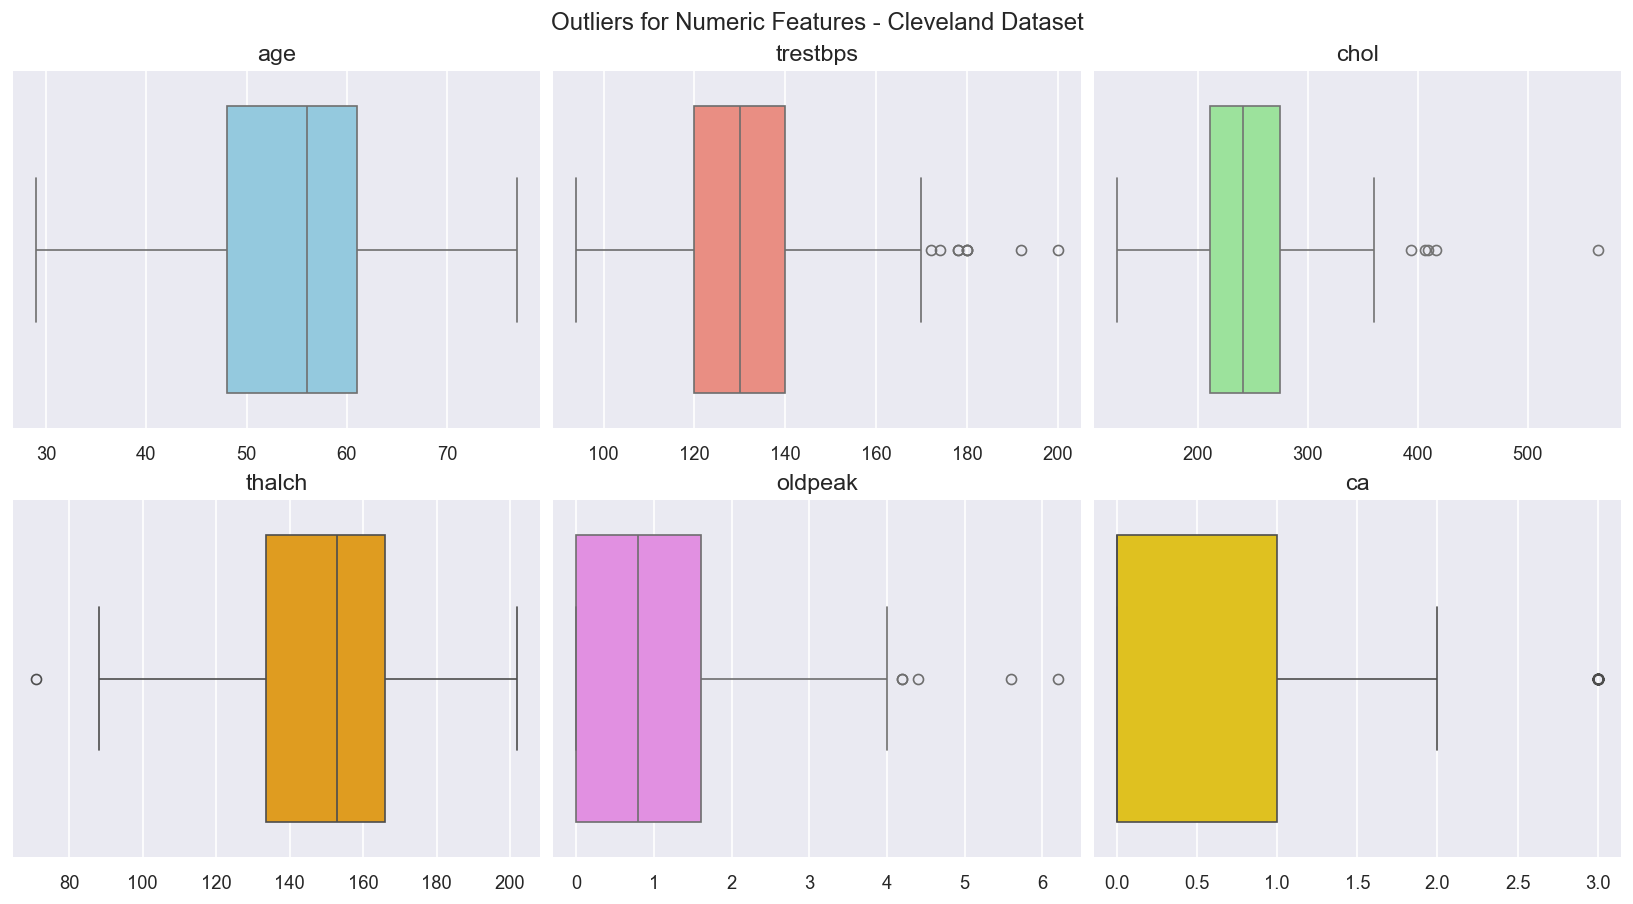

In [100]:
# Recheck outliers
# Show outliers for numeric columns
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4.5, n_rows * 3.5), constrained_layout=True)
axes = np.array(axes).reshape(-1)  # flatten in case of single row/col
for i, col in enumerate(numeric_cols):
    ax = axes[i]
    sns.boxplot(x = cleveland_clean[col], ax=ax, color=colors[i])
    ax.set_title(col)
    ax.set_xlabel("")

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

fig.suptitle("Outliers for Numeric Features - Cleveland Dataset")
plt.show()

In [95]:
# Simple cleanup example — adjust to your dataset needs
df_clean = cleveland_clean.copy()   # I want to try to keep it easy to replace cleveland_clean with simple_heart later
# just in case we missed any missing values
df_clean = df_clean.dropna(axis=0)


X = df_clean.drop(columns=[target_col])
y = df_clean[target_col]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y if len(y.unique()) > 1 else None, random_state=SEED
)

X_train.shape, X_test.shape

((239, 15), (60, 15))

## Models
### Baseline
- Try a few baseline models
- Majority-class baseline (sanity check)
- Logistic Regression baseline

In [ ]:
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

dummy = DummyClassifier(strategy="most_frequent", random_state=SEED)
try:
    dummy_auc = cross_val_score(dummy, X_train, y_train, cv=cv, scoring="roc_auc").mean()
    print("Dummy AUC (cv):", round(dummy_auc, 3))
except Exception as e:
    print("Dummy baseline issue (likely non-binary or labels not suitable for AUC):", e)

logreg = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=1000, random_state=SEED))
])

try:
    logreg_auc = cross_val_score(logreg, X_train, y_train, cv=cv, scoring="roc_auc").mean()
    print("Logistic Regression AUC (cv):", round(logreg_auc, 3))
except Exception as e:
    print("LogReg baseline issue:", e)

### Candidate Models
- Try a few standard classifiers with sane defaults
- Use StratifiedKFold for consistent estimates

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

candidates = {
    "LogReg": logreg,
    "SVC-rbf": Pipeline([("scaler", StandardScaler()), ("clf", SVC(kernel="rbf", probability=True, random_state=SEED))]),
    "RF": RandomForestClassifier(n_estimators=300, random_state=SEED)
}

for name, model in candidates.items():
    try:
        auc = cross_val_score(model, X_train, y_train, cv=cv, scoring="roc_auc").mean()
        print(f"{name:8s} AUC (cv): {auc:.3f}")
    except Exception as e:
        print(f"{name:8s} issue:", e)

### Fit Best Model and Evaluate on Test
- Fit on full train
- Evaluate on test with ROC/PR, confusion matrix, classification report

In [ ]:
# Choose best based on CV above
best_model = logreg  # replace if another model scored better
best_model.fit(X_train, y_train)

has_proba = hasattr(best_model, "predict_proba")
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1] if has_proba else None

try:
    print("Test ROC AUC:", roc_auc_score(y_test, y_proba) if y_proba is not None else "n/a")
except Exception as e:
    print("AUC issue:", e)

print(classification_report(y_test, y_pred))

if y_proba is not None:
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    RocCurveDisplay.from_predictions(y_test, y_proba, ax=ax[0])
    ax[0].set_title("ROC Curve")
    PrecisionRecallDisplay.from_predictions(y_test, y_proba, ax=ax[1])
    ax[1].set_title("Precision-Recall")
    plt.show()

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

## Interpretation
- Coefficients (for linear models)
- Feature importance (tree-based)
- Optional: partial dependence or permutation importance

In [ ]:
def try_show_importance(model, X_cols):
    try:
        # If pipeline, get final step
        final_est = model[-1] if isinstance(model, Pipeline) else model
    except Exception:
        final_est = model

    if hasattr(final_est, "coef_"):
        coefs = pd.Series(final_est.coef_.ravel(), index=X_cols)
        display(coefs.sort_values(ascending=False).head(10))
        display(coefs.sort_values(ascending=True).head(10))
    elif hasattr(final_est, "feature_importances_"):
        importances = pd.Series(final_est.feature_importances_, index=X_cols)
        display(importances.sort_values(ascending=False).head(10))
    else:
        print("No coefficients or feature_importances_ available.")

try_show_importance(best_model, X_train.columns)

## Conclusions and Next Steps
- Summary of findings
- What worked best and why
- Ideas for future improvements (feature engineering, calibration, fairness checks, external validation)

## Appendix
- Full parameter settings
- Utility functions
- Links to dataset and documentation

Style and usability tips:
- Use JupyterLab’s Table of Contents (View > Table of Contents) to keep sections navigable.
- Keep figures consistent by setting seaborn theme and matplotlib rcParams.
- Save key figures to a `figs` folder for reuse in reports.
- Limit long prints; prefer concise tables/plots.